In [112]:
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.applications import EfficientNetB0  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [140]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [141]:
# train_path = 'brain_tumor_dataset/Training'
# test_path = 'brain_tumor_dataset/Testing'
train_path = 'brain_tumor_dataset/Training_balanced'
test_path = 'brain_tumor_dataset/Testing_balanced'

In [142]:
train_df = train_df(train_path)
test_df = test_df(test_path)
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])
valid_df

,Class Path,Class
816,brain_tumor_dataset/Testing_balanced/meningiom...,meningioma
617,brain_tumor_dataset/Testing_balanced/meningiom...,meningioma
495,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
155,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor
1161,brain_tumor_dataset/Testing_balanced/glioma/Te...,glioma
...,...,...
421,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
418,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
115,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor
41,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor


In [143]:
num_classes = len(os.listdir(train_path))
num_classes

4

In [148]:
batch_size = 128
img_size = (224, 224)

train_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1/255)


train_gen = train_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = test_gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5284 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.


In [149]:
# Load the EfficientNetB0 model  
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  
  
# Freeze the base model  
base_model.trainable = False  

model = Sequential()
model.add(base_model)
# model.add(GlobalAveragePooling2D())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [150]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, restore_best_weights=True) 

epochs = 10 

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=[early_stopping]
)

/root/test_model/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 898ms/step - accuracy: 0.2708 - loss: 1.7005 - val_accuracy: 0.2500 - val_loss: 5.9464
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 884ms/step - accuracy: 0.3264 - loss: 1.4474 - val_accuracy: 0.2500 - val_loss: 6.2419
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 880ms/step - accuracy: 0.3581 - loss: 1.3889 - val_accuracy: 0.2500 - val_loss: 9.1563
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 855ms/step - accuracy: 0.3740 - loss: 1.3409 - val_accuracy: 0.2500 - val_loss: 8.2836
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 819ms/step - accuracy: 0.3869 - loss: 1.3147 - val_accuracy: 0.2983 - val_loss: 3.3196
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 676ms/step - accuracy: 0.4036 - loss: 1.2807 - val_accuracy: 0.2517 - val_loss: 5.3322
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 671ms/step - accuracy: 0.4000 - loss: 1.2569 - val_accuracy: 0.2700 - val_loss: 2.8704
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 804ms/step - accuracy: 0.3952 - loss: 1.2560 - val_accu

In [151]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=None) 

print(f"Test Loss: {round(test_loss,4)}")
print(f"Test Accuracy: {round(100*test_accuracy,2)}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.3709 - loss: 1.9704
Test Loss: 1.9935
Test Accuracy: 37.0%


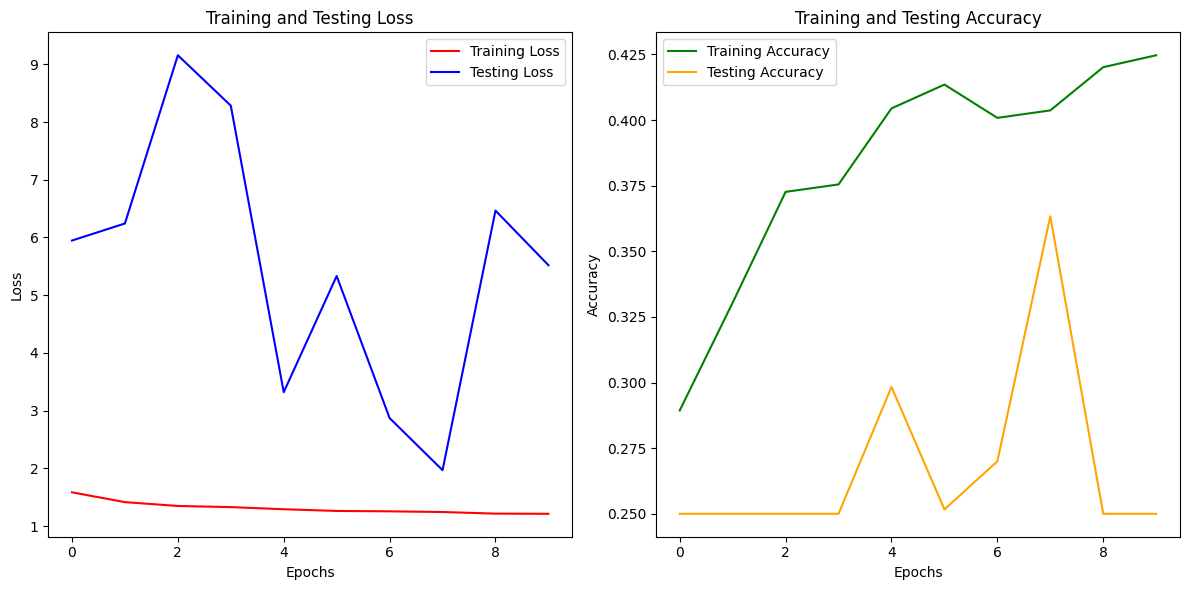

In [152]:
# Plotting training and testing loss in one graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Testing Loss', color='blue')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and testing accuracy in another graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy', color='orange')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step


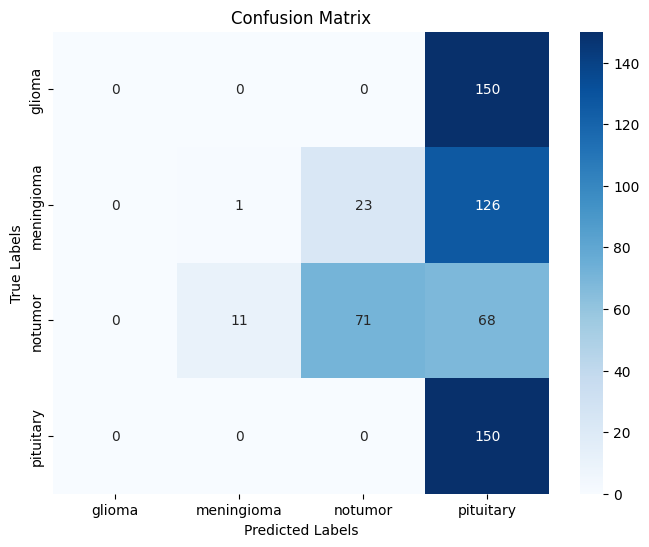

In [155]:
predicted_labels = np.argmax(model.predict(test_gen), axis=1)
true_labels = test_gen.classes

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [154]:
from sklearn.metrics import classification_report  
  
# Generate a classification report  
report = classification_report(true_labels, predicted_labels, target_names=test_gen.class_indices.keys())  
print(report)  


              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       150
  meningioma       0.08      0.01      0.01       150
     notumor       0.76      0.47      0.58       150
   pituitary       0.30      1.00      0.47       150

    accuracy                           0.37       600
   macro avg       0.29      0.37      0.27       600
weighted avg       0.29      0.37      0.27       600



/root/test_model/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/test_model/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/test_model/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [156]:
# Unfreeze some layers in the base model for fine-tuning  
for layer in base_model.layers[-20:]:  
    layer.trainable = True  
  
# Recompile the model with a lower learning rate  
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])  
  
# Continue training (fine-tuning)  
history_fine = model.fit(  
    train_gen,  
    epochs=5,  # Additional epochs for fine-tuning  
    validation_data=test_gen  
)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 47s 944ms/step - accuracy: 0.2364 - loss: 2.0694 - val_accuracy: 0.2500 - val_loss: 6.6086
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 910ms/step - accuracy: 0.2912 - loss: 1.4442 - val_accuracy: 0.2500 - val_loss: 3.9701
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 897ms/step - accuracy: 0.3113 - loss: 1.3694 - val_accuracy: 0.2500 - val_loss: 2.3365
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 916ms/step - accuracy: 0.3256 - loss: 1.3285 - val_accuracy: 0.3067 - val_loss: 1.5858
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 896ms/step - accuracy: 0.3711 - loss: 1.2904 - val_accuracy: 0.3500 - val_loss: 1.3432


In [157]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=None) 

print(f"Test Loss: {round(test_loss,4)}")
print(f"Test Accuracy: {round(100*test_accuracy,2)}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.3376 - loss: 1.3393
Test Loss: 1.3432
Test Accuracy: 35.0%


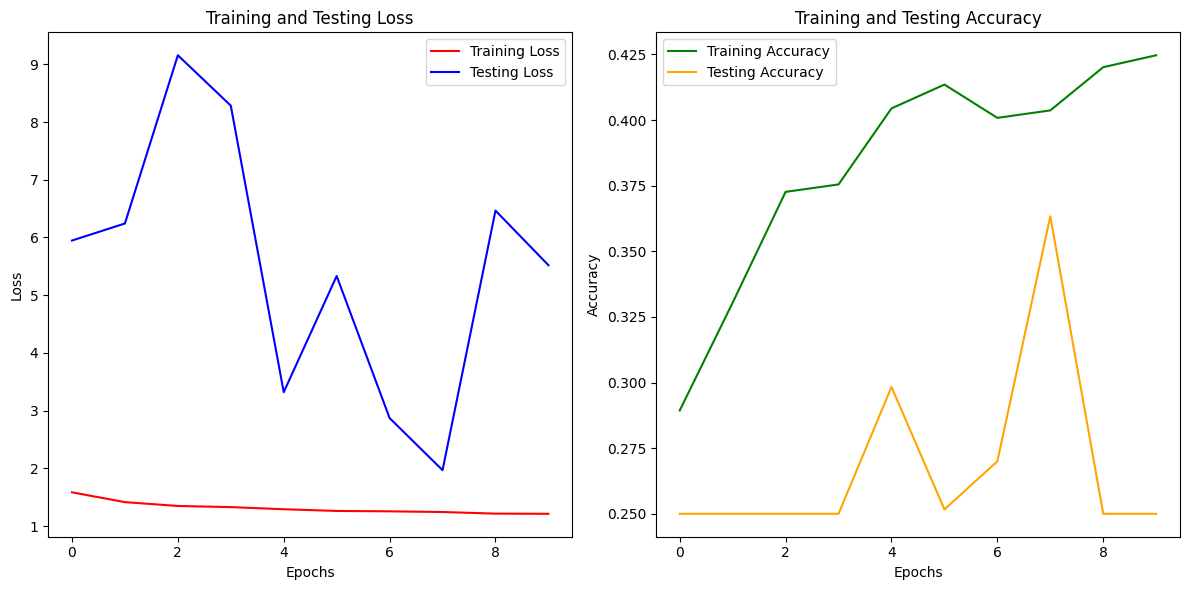

In [158]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Testing Loss', color='blue')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy', color='orange')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step


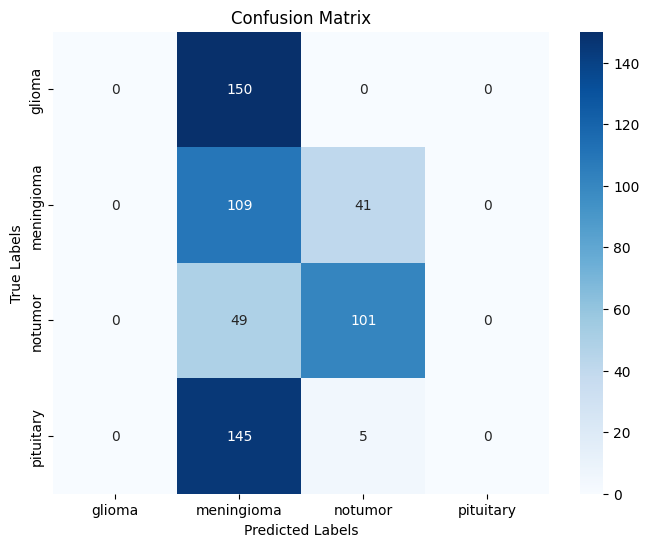

In [159]:
predicted_labels = np.argmax(model.predict(test_gen), axis=1)
true_labels = test_gen.classes

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [160]:
from sklearn.metrics import classification_report  
  
# Generate a classification report  
report = classification_report(true_labels, predicted_labels, target_names=test_gen.class_indices.keys())  
print(report)  


              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       150
  meningioma       0.24      0.73      0.36       150
     notumor       0.69      0.67      0.68       150
   pituitary       0.00      0.00      0.00       150

    accuracy                           0.35       600
   macro avg       0.23      0.35      0.26       600
weighted avg       0.23      0.35      0.26       600



/root/test_model/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/test_model/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/test_model/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [111]:
# model.save('efficientnetb0_brain_tumor.keras') 